<a href="https://colab.research.google.com/github/kamaleshpantra/Synthetic-Image-Detector/blob/main/Synthetic_Image_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Reproducibility

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

Project Paths

In [ ]:
PROJECT_ROOT = "/content/drive/MyDrive/synthetic-detector"
DATA_PATH = os.path.join(PROJECT_ROOT, "data")

TRAIN_PATH = os.path.join(DATA_PATH, "train")
TEST_PATH  = os.path.join(DATA_PATH, "test")

MODEL_DIR = os.path.join(PROJECT_ROOT, "outputs/models")
os.makedirs(MODEL_DIR, exist_ok=True)

print("Train path:", TRAIN_PATH)
print("Test path:", TEST_PATH)

Train path: /content/drive/MyDrive/synthetic-detector/data/train
Test path: /content/drive/MyDrive/synthetic-detector/data/test


Load CIFAKE Dataset

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_full_dataset = ImageFolder(root=TRAIN_PATH, transform=transform)
test_full_dataset  = ImageFolder(root=TEST_PATH, transform=transform)

print("Classes:", train_full_dataset.classes)
print("Train size:", len(train_full_dataset))
print("Test size:", len(test_full_dataset))

Classes: ['FAKE', 'REAL']
Train size: 30002
Test size: 10000


Balanced Subset

In [ ]:
targets = train_full_dataset.targets
indices = []

samples_per_class = 2000
class_counts = {0: 0, 1: 0}

for idx, label in enumerate(targets):
    if class_counts[label] < samples_per_class:
        indices.append(idx)
        class_counts[label] += 1

    if all(v == samples_per_class for v in class_counts.values()):
        break

train_subset = Subset(train_full_dataset, indices)

print("Balanced train subset:", len(train_subset))
print("Class distribution:", class_counts)

Balanced train subset: 4000
Class distribution: {0: 2000, 1: 2000}


In [ ]:
targets = test_full_dataset.targets
indices = []

samples_per_class = 500
class_counts = {0: 0, 1: 0}

for idx, label in enumerate(targets):
    if class_counts[label] < samples_per_class:
        indices.append(idx)
        class_counts[label] += 1

    if all(v == samples_per_class for v in class_counts.values()):
        break

test_subset = Subset(test_full_dataset, indices)

print("Balanced test subset:", len(test_subset))
print("Class distribution:", class_counts)

Balanced test subset: 1000
Class distribution: {0: 500, 1: 500}


Train / Validation Split

In [ ]:
train_size = int(0.85 * len(train_subset))
val_size = len(train_subset) - train_size

train_dataset, val_dataset = random_split(
    train_subset,
    [train_size, val_size]
)

print("Final Train:", len(train_dataset))
print("Validation:", len(val_dataset))

Final Train: 3400
Validation: 600


Data Loader

In [ ]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=0)

print("DataLoaders ready.")

DataLoaders ready.


Build ResNet18

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze early layers
for param in list(model.parameters())[:-10]:
    param.requires_grad = False

num_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 2)
)

model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = GradScaler()

print("Model ready.")

Model ready.


/tmp/ipython-input-1926619860.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training & Validation

In [ ]:
def validate(model, loader):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Validation Loss: {val_loss/len(loader):.4f}")
    print(f"Validation Accuracy: {correct/total:.4f}")


def train_model(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        print(f"\nEpoch [{epoch+1}/{epochs}] Train Loss: {train_loss/len(train_loader):.4f}")
        validate(model, val_loader)

        # Safety checkpoint
        if (epoch+1) % 2 == 0:
            torch.save(model.state_dict(), os.path.join(MODEL_DIR, "temp_checkpoint.pth"))

Train

In [ ]:
train_model(model, train_loader, val_loader, epochs=3)

  0%|          | 0/54 [00:00<?, ?it/s]/tmp/ipython-input-2067599862.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 54/54 [31:56<00:00, 35.50s/it]



Epoch [1/3] Train Loss: 0.4517
Validation Loss: 0.4141
Validation Accuracy: 0.8667


100%|██████████| 54/54 [00:19<00:00,  2.74it/s]



Epoch [2/3] Train Loss: 0.3692
Validation Loss: 0.3943
Validation Accuracy: 0.8933


100%|██████████| 54/54 [00:19<00:00,  2.81it/s]



Epoch [3/3] Train Loss: 0.3432
Validation Loss: 0.3893
Validation Accuracy: 0.8883


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))

CUDA available: True
Current device: 0
Device name: Tesla T4


Evaluation

In [ ]:
def evaluate_model(model, loader):
    model.eval()

    all_preds = []
    all_labels = []
    fake_confidences = []
    real_confidences = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

            for i in range(len(labels)):
                if labels[i] == 1:
                    fake_confidences.append(probs[i,1].item())
                else:
                    real_confidences.append(probs[i,0].item())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("Accuracy:", acc)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Average confidence (Real):", np.mean(real_confidences))
    print("Average confidence (Fake):", np.mean(fake_confidences))

    return all_labels, all_preds, fake_confidences, real_confidences

In [ ]:
labels, preds, fake_conf, real_conf = evaluate_model(model, test_loader)

Accuracy: 0.891
Precision: 0.9315673289183223
Recall: 0.844
F1 Score: 0.8856243441762854
Average confidence (Real): 0.865260048199445
Average confidence (Fake): 0.7556760718263685


Confusion Matrix

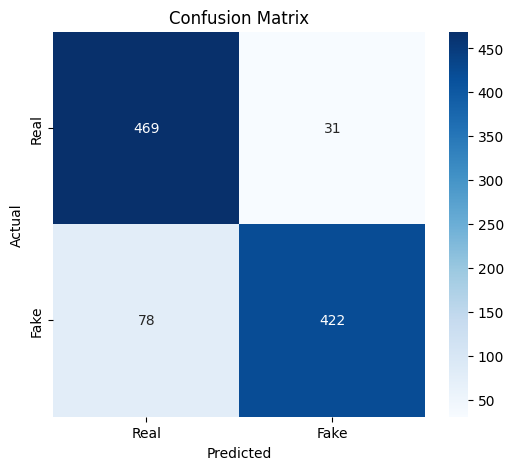

In [ ]:
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Confidence Distribution

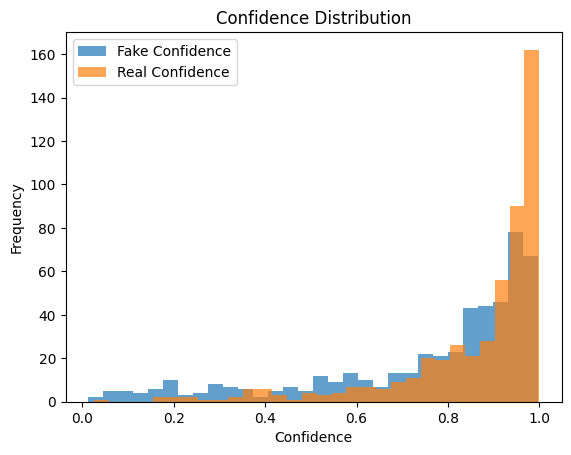

In [ ]:
plt.hist(fake_conf, bins=30, alpha=0.7, label="Fake Confidence")
plt.hist(real_conf, bins=30, alpha=0.7, label="Real Confidence")
plt.legend()
plt.title("Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()

Save Final Model

In [ ]:
MODEL_PATH = os.path.join(MODEL_DIR, "resnet18_synthetic_detector.pth")
torch.save(model.state_dict(), MODEL_PATH)

print(f"Model saved at {MODEL_PATH}")

Model saved at /content/drive/MyDrive/synthetic-detector/outputs/models/resnet18_synthetic_detector.pth


In [14]:
from google.colab import drive
drive.mount("/content/drive")

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
PROJECT_ROOT = "/content/drive/MyDrive/Hackathon 21 2/synthetic-detector"

TRAIN_PATH = f"{PROJECT_ROOT}/data/train"
TEST_PATH  = f"{PROJECT_ROOT}/data/test"

MODEL_PATH = f"{PROJECT_ROOT}/outputs/models/resnet18_synthetic_detector.pth"

print("TRAIN_PATH:", TRAIN_PATH)
print("TEST_PATH :", TEST_PATH)
print("MODEL_PATH:", MODEL_PATH)

print("Train exists:", os.path.exists(TRAIN_PATH))
print("Test exists :", os.path.exists(TEST_PATH))
print("Model exists:", os.path.exists(MODEL_PATH))

TRAIN_PATH: /content/drive/MyDrive/Hackathon 21 2/synthetic-detector/data/train
TEST_PATH : /content/drive/MyDrive/Hackathon 21 2/synthetic-detector/data/test
MODEL_PATH: /content/drive/MyDrive/Hackathon 21 2/synthetic-detector/outputs/models/resnet18_synthetic_detector.pth
Train exists: True
Test exists : True
Model exists: True


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [17]:
state_cpu = torch.load(MODEL_PATH, map_location="cpu")

# hidden dim is the out_features of first fc layer: fc.0.weight shape = (hidden_dim, in_features)
hidden_dim = state_cpu["fc.0.weight"].shape[0]
print("Detected hidden_dim from checkpoint:", hidden_dim)

def build_teammate_resnet18(num_classes=2, hidden_dim=512):
    m = resnet18(weights=ResNet18_Weights.DEFAULT)
    in_features = m.fc.in_features

    m.fc = nn.Sequential(
        nn.Linear(in_features, hidden_dim),  # fc.0
        nn.BatchNorm1d(hidden_dim),          # fc.1
        nn.ReLU(inplace=True),              # fc.2
        nn.Dropout(p=0.4),                  # fc.3 (p=0.4 as per teammate)
        nn.Linear(hidden_dim, num_classes)  # fc.4
    )
    return m

model = build_teammate_resnet18(num_classes=2, hidden_dim=hidden_dim).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device), strict=True)
model.eval()

print("✅ Model loaded successfully and ready for XAI.")

Detected hidden_dim from checkpoint: 512
✅ Model loaded successfully and ready for XAI.


In [19]:
xai_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

xai_test_dataset = ImageFolder(root=TEST_PATH, transform=xai_transform)
class_names = xai_test_dataset.classes
print("Class folders:", class_names)

xai_test_loader = DataLoader(
    xai_test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

Class folders: ['FAKE', 'REAL']
